# Grids Specific to Maui Example: Method of Fragments

This notebook presents an example application of SWB in a location for which convenient gridded weather data do not exist. A complete, working example involving application of the method of fragments is presented.

## Preliminaries

In [119]:
import os
import numpy as np
import pandas as pd
import gdal

%run plot_and_table_functions.py

rainfall_fragments_file        = '../input/rain_fragments_maui_reduced_case.prn'
rainfall_sequence_file         = '../input/frag_sequence_2yrs_5sims.out'
sample_monthly_rainfall_file   = '../input/month_year_rainfall/maui_prcp_01_2002.asc'
monthly_rainfall_adj_file      = '../input/Maui_RF_adj_factors/maui_RF_adj_jan__50m.asc'
soil_storage_gridfile_fname    = '../input/maui_SOIL_MOISTURE_STORAGE__50m.asc'
rain_zone_id_file              = '../input/maui_RAIN_ZONE__50m.asc'

## Introduction

The Method of Fragments approach highlighted here is used because there is no reliable source for daily gridded rainfall and air temperature data for Maui. A good overview of the method is given by Engott (2011):
> Daily rainfall was synthesized by disaggregating the 
> monthly rainfall values using the method of fragments (see, 
> for example, Oki, 2002). The method creates a synthetic 
> sequence of daily rainfall from monthly data by imposing the 
> rainfall pattern from a rain gage with daily data. Fragments 
> were created by dividing each daily rainfall measurement for 
> a particular month by the total rainfall for that month. This 
> created a set of fragments for that particular month in which 
> the total number of fragments was equal to the number of days 
> in the month. Fragment sets were created for every gage for 
> every month in which complete daily rainfall measurements 
> were available. Fragment sets were grouped by month of the 
> year and by rain gage. The fragment set to be used for a given 
> gage for a given month was selected randomly from among all 
> available sets for that gage for that month of the year. Synthesized 
> daily rainfall for a given month was created by multiplying 
> total rainfall for that month by each fragment in the set, 
> thereby providing daily rainfall.

The approach incorporated into SWB was developed and improved in the course of development of the Hawaii Water Budget (HWB) code (Oki, 2002, Izuka and others, 2010, Engott, 2011). Typically, HWB would be run 20 to 30 times, allowing the code to select from the available rainfall fragments at random from the __fragments file__ during each run. In the end, the results of all model runs would be averaged together in order to produce the final net infiltration (recharge) map. The idea here was to average away the variability introduced by use of a differing sequence of rainfall fragments.

Letting the code choose rainfall fragments at random, however, makes it very difficult to compare a single run to another. Therefore, another option that may be used is to supply SWB with a __sequence file__, which simply specifies in advance the sequence of rainfall fragments that will be used. When used this way, the same sequence of rainfall fragments will be used from one run to the next, which makes comparison of results much easier.

## Fragments file

The fragments file is a plaintext, headerless ASCII table that contains the actual monthly fragment series used to disaggregate the monthly data. Header labels have been added to the example below to assist in interpreting the columns properly. The first three columns of the fragments file hold the numerical month value (1-12), the gage ID corresponding to the climate station used to generate the fragments, and the fragment set number. For a rainfall gage with a 5-year period of record, the fragment set values would be in the range of 1 to 5; for a gage with 30 years of record, the fragment set values would range from 1 to 30.

In [120]:
# open fragment file
collabels1 = ['Month','Gage ID','Fragment Set']
collabels2 = ['day ' + str(d) for d in range(1,32,1) ]
fragments     = pd.read_table( rainfall_fragments_file, delim_whitespace=True, 
                               names=collabels1 + list(collabels2) )
fragments = fragments.loc[0:55,:]

In [121]:
print_df_no_index( fragments )

Month,Gage ID,Fragment Set,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,day 11,day 12,day 13,day 14,day 15,day 16,day 17,day 18,day 19,day 20,day 21,day 22,day 23,day 24,day 25,day 26,day 27,day 28,day 29,day 30,day 31
1,1,1,0.1895,0.0000,0.0000,0.0000,0.1684,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1053,0.1263,0.0000,0.0000,0.0000,0.0000,0.0316,0.0000,0.0000,0.0000,0.0000,0.1053,0.0000,0.0000,0.2737,0.0000,0.0000,0.0000,0.0000
1,2,1,0.0463,0.0000,0.0366,0.0171,0.0341,0.0000,0.0000,0.3244,0.0146,0.0024,0.0146,0.0098,0.0000,0.0000,0.0000,0.1756,0.0000,0.0000,0.0000,0.0000,0.0024,0.0024,0.0878,0.0390,0.0000,0.1098,0.0000,0.0024,0.0146,0.0317,0.0341
1,3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1938,0.0089,0.0287,0.0682,0.0172,0.0127,0.0605,0.0319,0.1039,0.1836,0.0019,0.0191,0.0000,0.0268,0.0000,0.0172,0.0064,0.0236,0.0000,0.1160,0.0797,0.0000,0.0000,0.0000,0.0000
1,4,1,0.1571,0.0000,0.0000,0.0000,0.0239,0.0000,0.0000,0.2425,0.0000,0.0437,0.0000,0.0934,0.0000,0.0000,0.2207,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0716,0.0000,0.0000,0.0000,0.0855,0.0616
1,5,1,0.0000,0.0000,0.0105,0.0000,0.0326,0.0035,0.0000,0.3488,0.3372,0.0000,0.0000,0.0000,0.0000,0.0000,0.0256,0.0000,0.0000,0.0000,0.0000,0.1023,0.0000,0.0000,0.0942,0.0000,0.0000,0.0000,0.0453,0.0000,0.0000,0.0000,0.0000
1,6,1,0.0883,0.1262,0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0394,0.0000,0.0000,0.7224,0.0142,0.0000,0.0000,0.0063,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0016
1,7,1,0.0000,0.0992,0.0000,0.0000,0.2290,0.0382,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5573,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0763,0.0000,0.0000,0.0000,0.0000
1,8,1,0.0171,0.0553,0.0066,0.1566,0.0092,0.0368,0.0184,0.0079,0.0132,0.0382,0.0000,0.0053,0.0000,0.0000,0.0092,0.0053,0.2842,0.0263,0.0000,0.0000,0.2592,0.0461,0.0000,0.0000,0.0000,0.0000,0.0053,0.0000,0.0000,0.0000,0.0000
1,9,1,0.1895,0.0000,0.0000,0.0000,0.1684,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1053,0.1263,0.0000,0.0000,0.0000,0.0000,0.0316,0.0000,0.0000,0.0000,0.0000,0.1053,0.0000,0.0000,0.2737,0.0000,0.0000,0.0000,0.0000
1,10,1,0.0202,0.0250,0.0123,0.0515,0.1312,0.1056,0.1287,0.0149,0.0171,0.0155,0.0136,0.0111,0.0266,0.0901,0.0145,0.1622,0.0553,0.0022,0.0076,0.0000,0.0016,0.0009,0.0092,0.0022,0.0452,0.0006,0.0009,0.0003,0.0003,0.0329,0.0003


If we sum up the values from a single row running from 'day 1' through 'day 31', we end up with a number very close to 1, as expected:

In [122]:
gage_2_fragments_jan = fragments.loc[1,'day 1':'day 31'].values
sum(gage_2_fragments_jan)

0.99969999999999981

## Sequence file

The sequence file provides SWB with a prescribed set of rainfall fragments with which to generate daily rainfall. When using a sequence file, the control file statement `FRAGMENTS_SEQUENCE_SIMULATION_NUMBER` must be supplied in order to specify the appropriate subset of sequence values to pull out of the sequence file. Unlike the other lookup tables, SWB ignores the column labels, and the columns must be present in the order shown below. The columns present in the file include:

|Column Name    |  Description                 |
|---------------|------------------------------|
|simulation     | Simulation number to use in subsetting the sequence file; if `FRAGMENTS_SEQUENCE_SIMULATION_NUMBER` is specified as '4', as an example, only the rows for which the `simulation` column equals 4 will be used in the current SWB run.|
| month         | Numerical month label (1-12) corresponding to the rainfall fragment |
| frag_zone     | frag_zone = fragment_zone = rainfall_gage_id; unfortunately many different names have been applied to the same thing. Fortunately, SWB doesn't care what you call it!
| year          | Index value corresponding to the current year of simulation. For example, in a run spanning 2000 to 2005, the first year would be 1, the last would be 6. |
| random_number | Value between 0.0 and 1.0; in this example it is the raw output from an external random number generator (Excel). SWB takes the random value and uses it to 'map' to the corresponding fragment set.
| selected_set  | This is the set that should be selected based on the number of valid fragment sets for the current gage ID (frag_zone).

The sequence file used for the Maui example is shown below. Again, the purpose is to ensure that each time the model is run, a predictable and consistent set of rainfall fragments is supplied to the model so that comparisons may be made between different model runs without the random selection process to confound analysis.

In [123]:
# open sequence file
sequence     = pd.read_table( rainfall_sequence_file, delim_whitespace=True )
sequence = sequence.loc[0:130,:]
print_df_no_index( sequence )

simulation,month,frag_zone,year,random_number,selected_set
1,1,1,1,0.000048,1
1,1,1,2,0.332207,4
1,1,2,1,0.178499,7
1,1,2,2,0.776854,30
1,1,3,1,0.528656,21
1,1,3,2,0.766643,30
1,1,4,1,0.271193,16
1,1,4,2,0.040817,3
1,1,5,1,0.170636,11
1,1,5,2,0.675147,41


In [124]:
# read in grid values - using 'read_raster' function taken from Andy Leaf's
# GISio.py package: https://github.com/aleaf/GIS_utils
rz_data, rz_gt, rz_proj, rz_xy                     = read_raster( rain_zone_id_file )
myrain_data, myrain_gt, myrain_proj, myrain_xy     = read_raster( sample_monthly_rainfall_file )
rainadj_data, rainadj_gt, rainadj_proj, rainadj_xy = read_raster( monthly_rainfall_adj_file )


reading in ../input/maui_RAIN_ZONE__50m.asc into numpy array...
creating a grid of xy coordinates in the original projection...

reading in ../input/month_year_rainfall/maui_prcp_01_2002.asc into numpy array...
creating a grid of xy coordinates in the original projection...

reading in ../input/Maui_RF_adj_factors/maui_RF_adj_jan__50m.asc into numpy array...
creating a grid of xy coordinates in the original projection...


## Make plots of input datasets

### Rain Gage ID (Fragment Zone)

One step in the method of fragments involves partitioning the model domain into a set of Thiessen polygons centered on the rainfall gages. The rain gage ID grid simply supplies this index value to SWB for each grid cell.

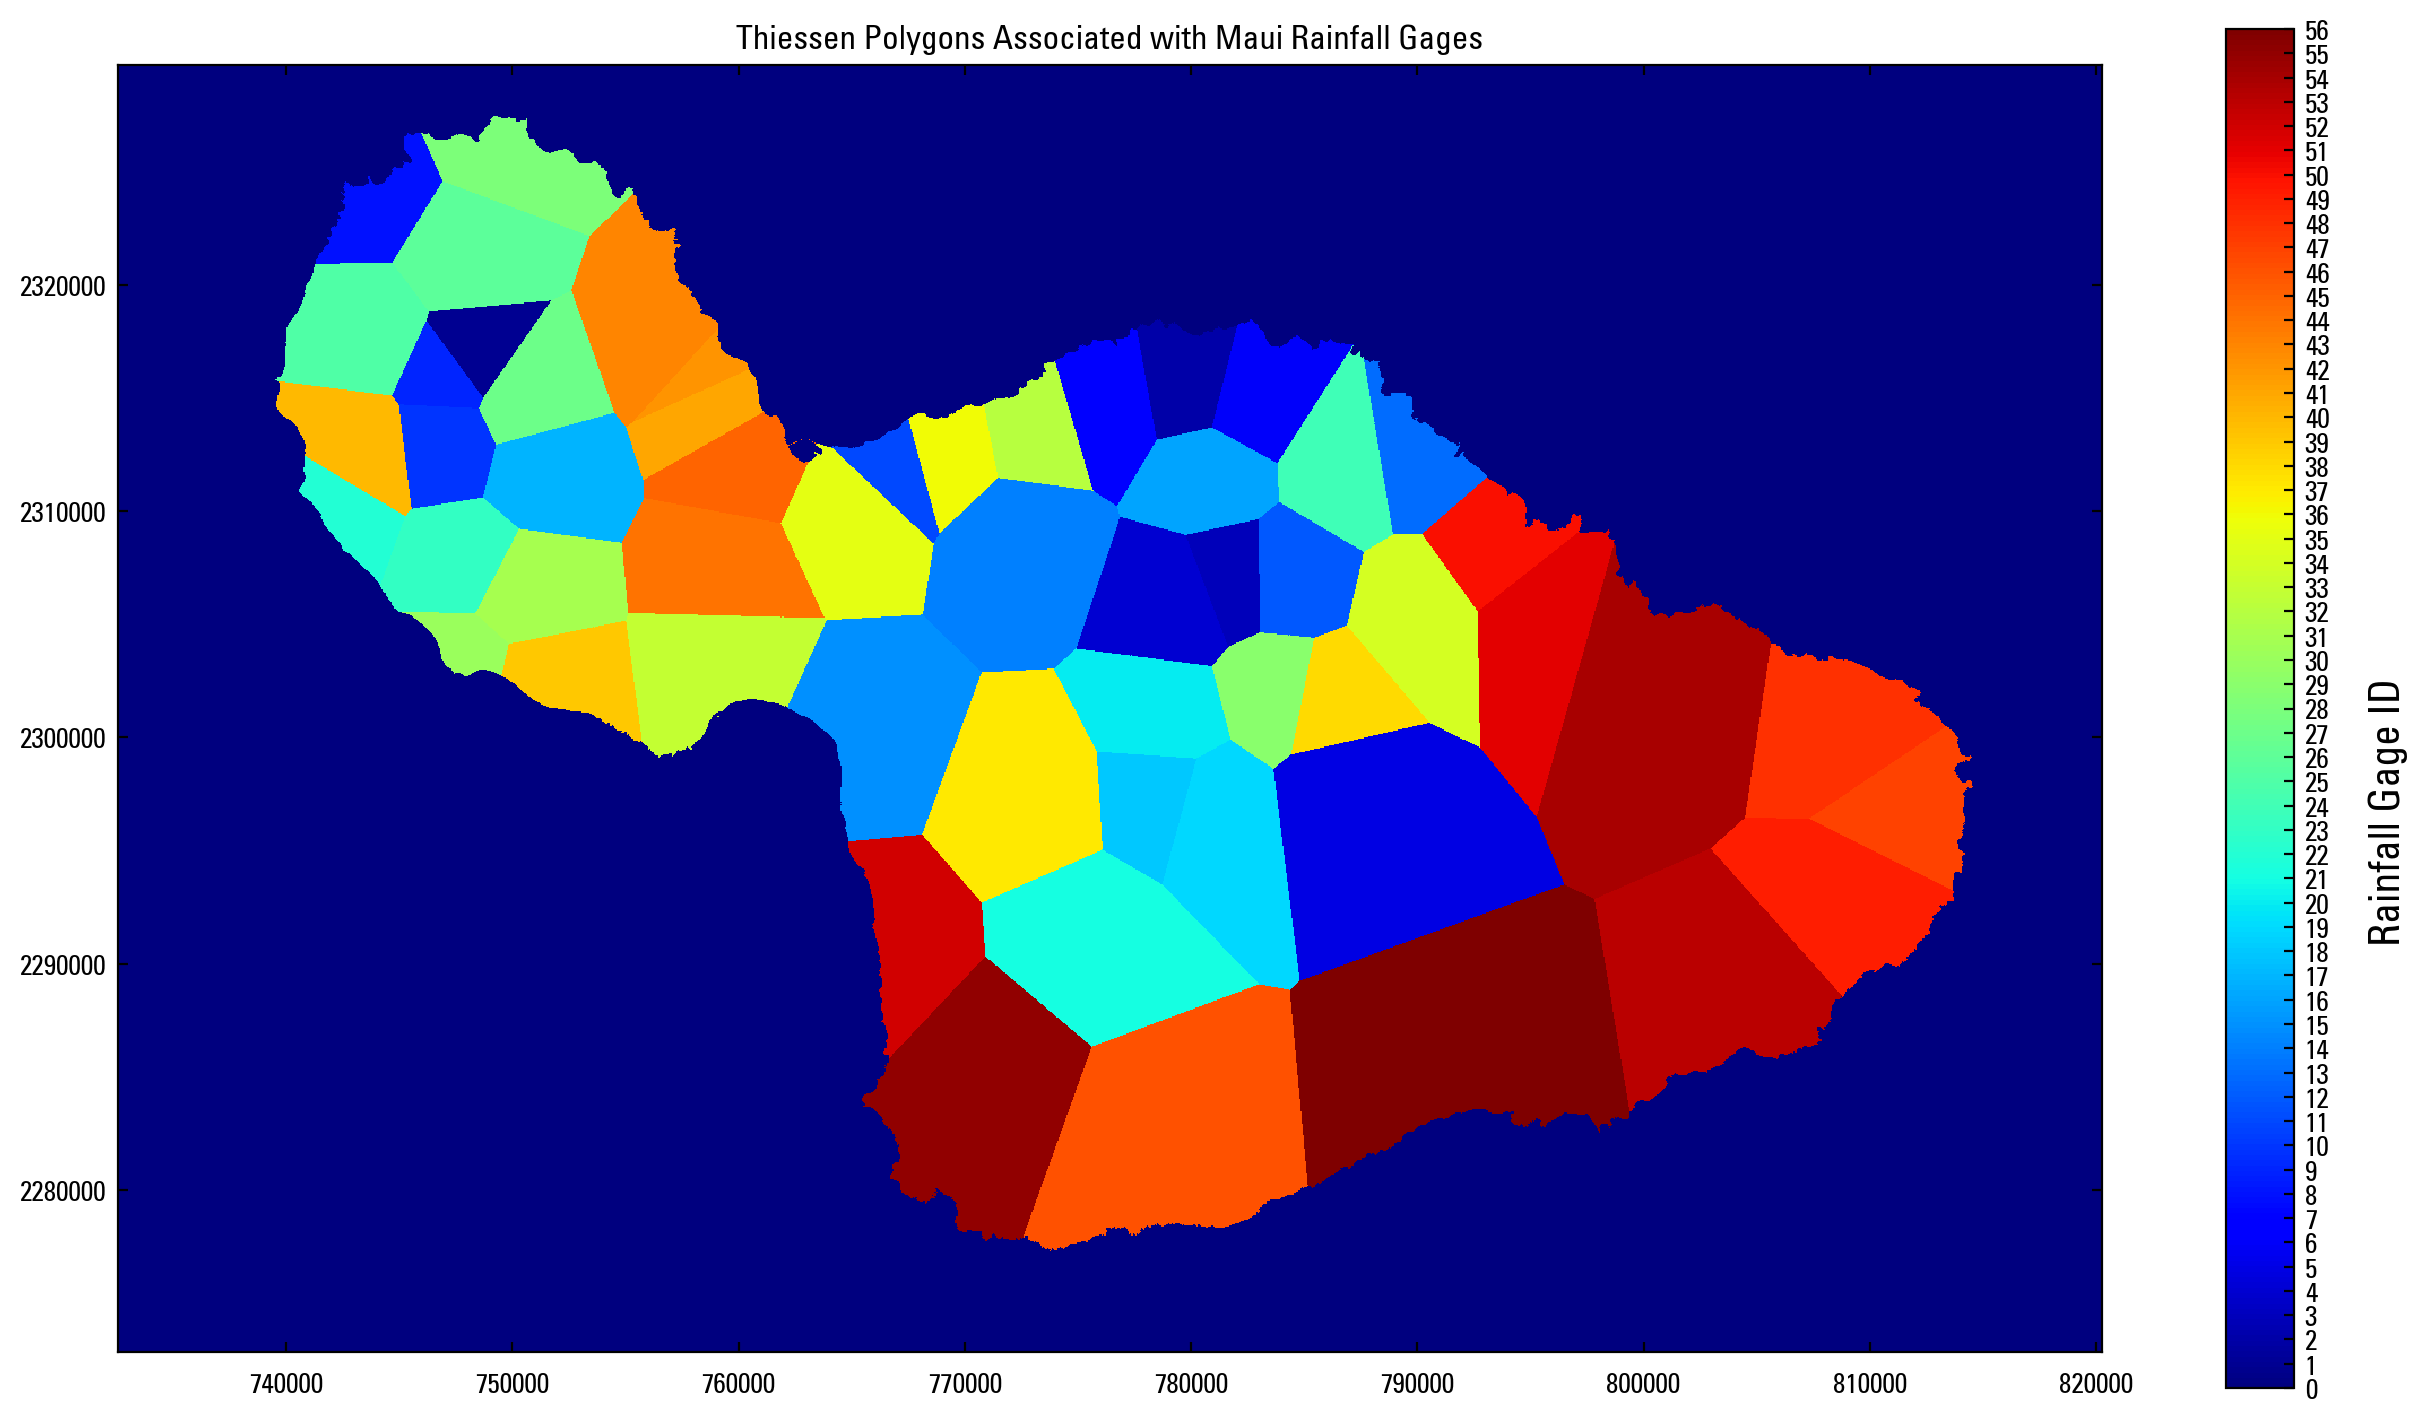

In [125]:
make_plot( x=rz_xy[0], y=rz_xy[1], var=rz_data, discrete=True,
           title='Thiessen Polygons Associated with Maui Rainfall Gages',
           barlabel="Rainfall Gage ID")

### Month-Year Rainfall Grid

The set of month-year rainfall grids discussed earlier provides a smooth interpolated surface convenient for distributing rainfall to the various grid cells. SWB reads in a new grid each month and uses the values as the basis for disaggregated daily values.

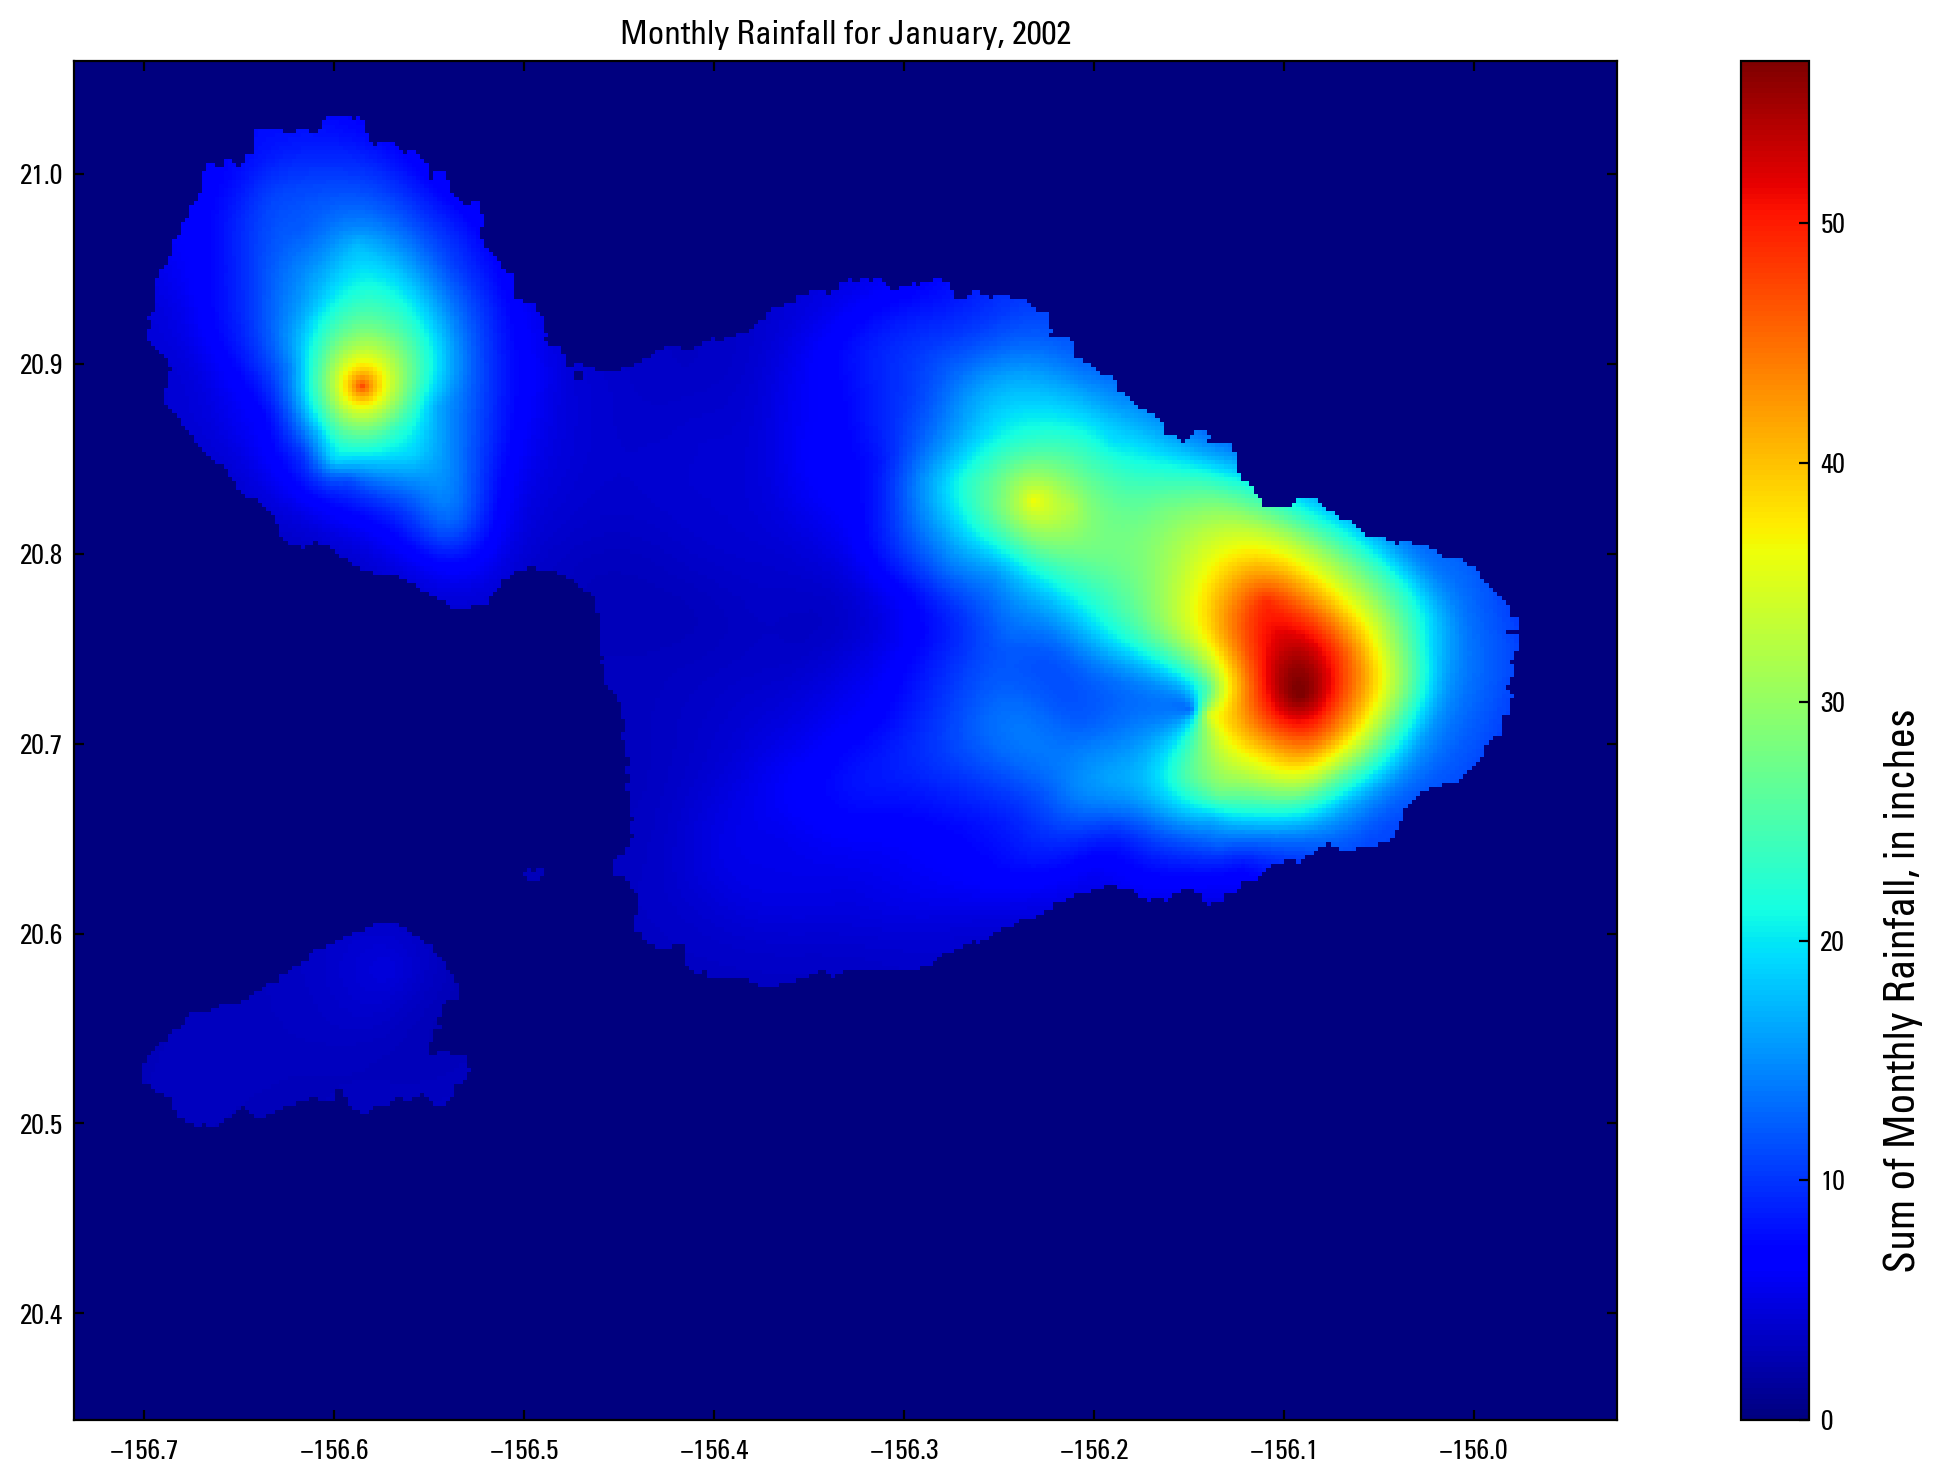

In [126]:
make_plot( x=myrain_xy[0], y=myrain_xy[1], var=myrain_data, discrete=False,
           title='Monthly Rainfall for January, 2002',
           barlabel="Sum of Monthly Rainfall, in inches")

### Rainfall Adjustment Factor Grid

For Hawai\`i, a published rainfall atlas exists along with the set of month-year rainfall grids. In order to force the disaggregated daily values to sum to values approximated by the published rainfall atlas, a series of rainfall adjustment grids was developed. For many applications, this may be replaced with a constant value of 1.0.

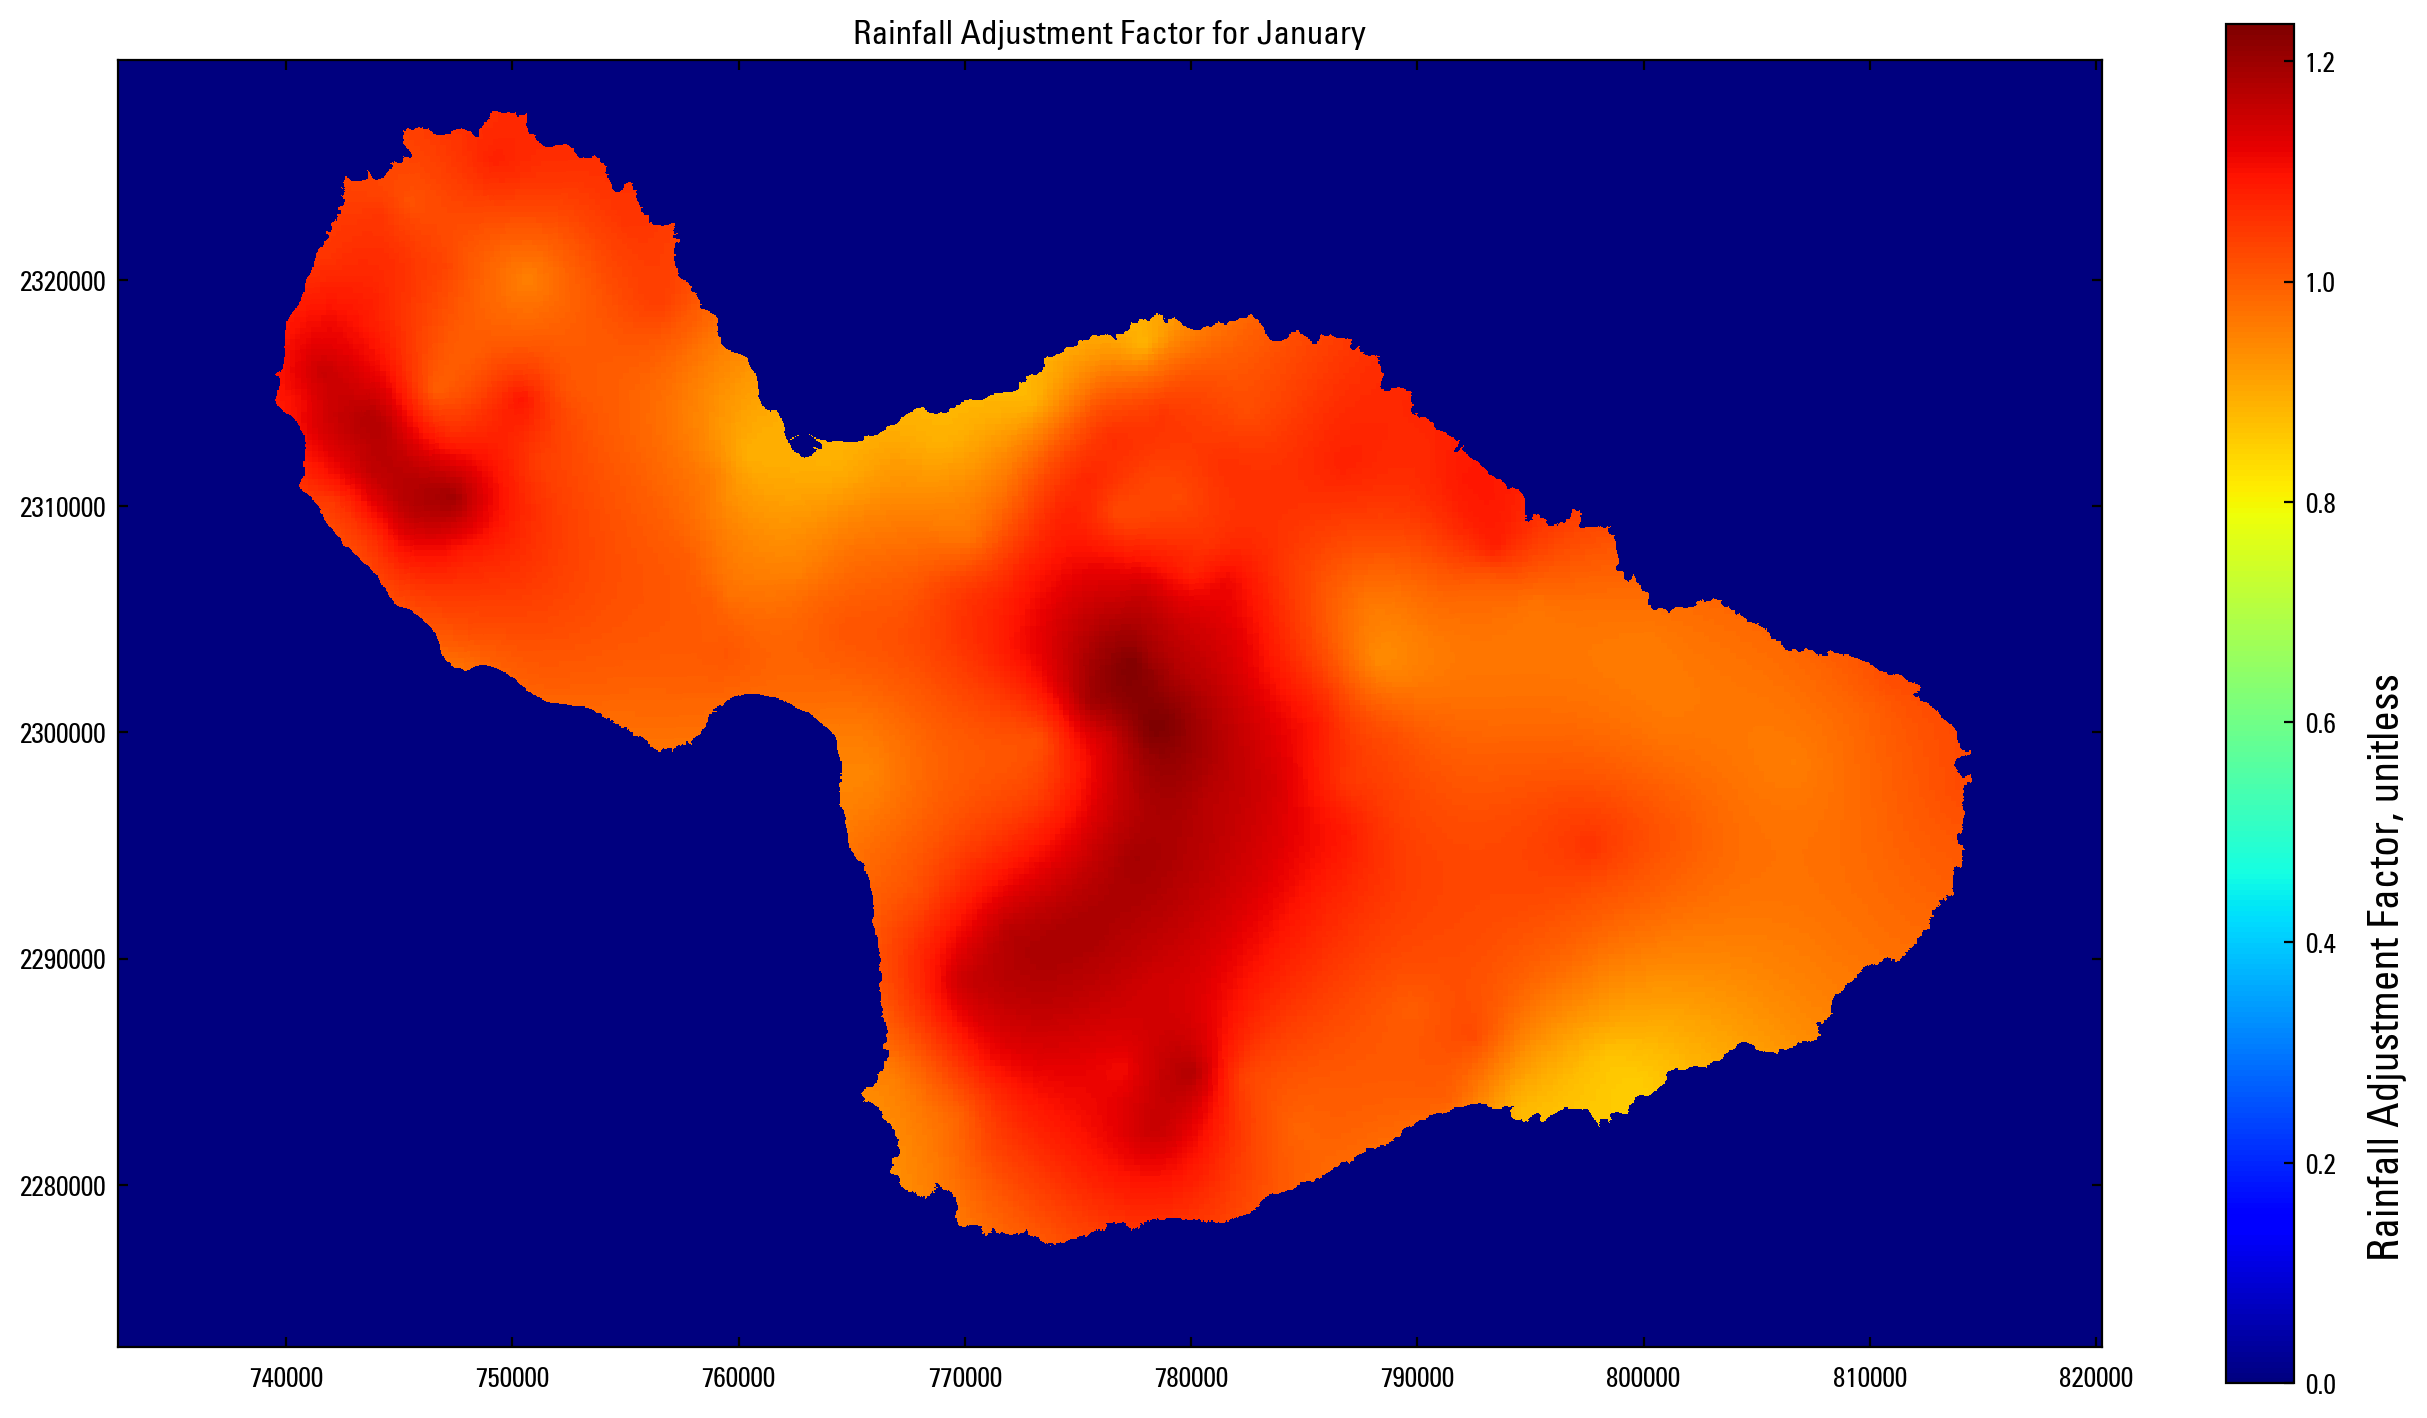

In [127]:
make_plot( x=rainadj_xy[0], y=rainadj_xy[1], var=rainadj_data, discrete=False,
           title='Rainfall Adjustment Factor for January',
           barlabel="Rainfall Adjustment Factor, unitless")

## Daily Rainfall Calculation

The daily rainfall amount for a particular grid cell is found by first calculating a monthly value for the grid cell, then by disggregating that monthly value into a series of daily values by means of the method of fragments.

A time series of month-year grids was prepared for Maui by Abby Frazier of the University of Hawai\`i at Manoa, covering the time period January, 1920, to December, 2012 (Frazier and others, 2016); each month within that timespan has its own gridded monthly rainfall file. Another recently published set of mean monthly rainfall grids was produced as part of an online rainfall atlas for Hawai\`i (Giambelluca and others, 2013). A monthly adjustment factor grid was developed in order to bring the estimated month-year grid values into better agreement with the rainfall atlas values. If no such adjustment were needed, the rainfall adjustment factor grid could be set to a constant value of 1.0.

The monthly value is found as:

$Rain_{monthly}=Rain_{month, year} * Adjustment_{rainfall}$

The calculation is demonstrated below for a single grid cell. This calculation is repeated by SWB for each grid cell in the model domain. Note that if we were using a sequence file with `FRAGMENTS_SEQUENCE_SIMULATION_NUMBER 1` in the control file, the sequence file specifies that fragment 1 from the fragments file would be used to perform the daily disaggregation.

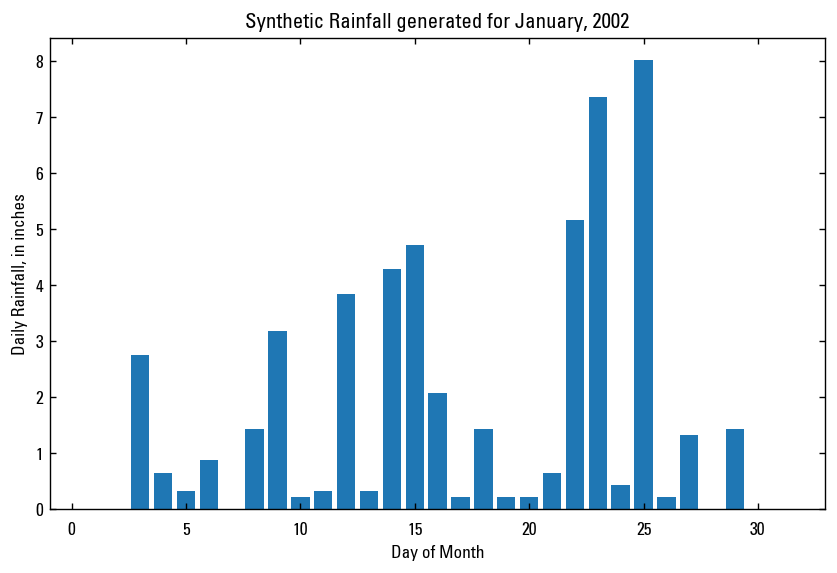

In [128]:
# find the index value for the cell with the largest rainfall amount
indx                = myrain_data.flatten().argmax()
month_year_rainfall = myrain_data.flatten()[ indx ]

adjustment_factor   = 0.91    # estimated from plot

# the rainfall gage ID is also eyeballed from the plot; in this case the fragment is for
# month 1 (January), rainfall gage 48, fragment set #1
fragments_snippet = fragments.loc[ 47, 'day 1':'day 31'].values

disaggregated_rainfall = month_year_rainfall * adjustment_factor * fragments_snippet

plt.figure(num=None, figsize=(8, 5), dpi=125, facecolor='w', edgecolor='k' )
plt.title('Synthetic Rainfall generated for January, 2002')
plt.ylabel('Daily Rainfall, in inches')
plt.xlabel('Day of Month')
plt.bar( range(1,32,1), disaggregated_rainfall )

plt.show()

## Control file entries

A complete SWB version 2.0 control file is shown below. The items that needed to be changed in order to use the method of fragments are:
    
1. set 'PRECIPITATION_METHOD' in block 1 to 'METHOD_OF_FRAGMENTS', and
2. specify the tables and grids highlighted in this notebook in block 3.

```
GRID   316    210    739800.    2276900.           250.
BASE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

(1) Module Specification
-------------------------

INTERCEPTION_METHOD              GASH
EVAPOTRANSPIRATION_METHOD        MONTHLY_GRID
RUNOFF_METHOD                    RUNOFF_RATIO
SOIL_MOISTURE_METHOD             FAO-56
PRECIPITATION_METHOD             METHOD_OF_FRAGMENTS
FOG_METHOD                       MONTHLY_GRID
FLOW_ROUTING_METHOD              NONE
IRRIGATION_METHOD                FAO-56
CROP_COEFFICIENT_METHOD          FAO-56
DIRECT_RECHARGE_METHOD           GRIDDED
SOIL_STORAGE_MAX_METHOD          GRIDDED
AVAILABLE_WATER_CONTENT_METHOD   TABLE


(2) Initial conditions for soil moisture, snow
-----------------------------------------------

INITIAL_PERCENT_SOIL_MOISTURE    CONSTANT 50.0
INITIAL_SNOW_COVER_STORAGE       CONSTANT 0.0


(3) Daily rainfall-related grids and data
------------------------------------------

PRECIPITATION ARC_GRID input/month_year_rainfall/maui_prcp_%0m_%Y.asc
PRECIPITATION_GRID_PROJECTION_DEFINITION +proj=lonlat +datum=WGS84 +no_defs

FRAGMENTS_DAILY_FILE input/rain_fragments_maui_reduced_case.prn
FRAGMENTS_SEQUENCE_FILE input/frag_sequence_2yrs_5sims.out
FRAGMENTS_SEQUENCE_SIMULATION_NUMBER 1

RAINFALL_ZONE ARC_GRID input/maui_RAIN_ZONE__50m.asc
RAINFALL_ZONE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

RAINFALL_ADJUST_FACTOR ARC_GRID input/Maui_RF_adj_factors/maui_RF_adj_%b__50m.asc
RAINFALL_ADJUST_FACTOR_PROJECTION_DEFINITION  +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
RAINFALL_ADJUST_FACTOR_MONTHNAMES_LOWERCASE


(4) Monthly air temperature grids
----------------------------------

TMAX ARC_GRID input/Air_Temperature_Monthly/Tmax%b_250m_maui.asc
TMAX_GRID_PROJECTION_DEFINITION +proj=lonlat +datum=WGS84 +no_defs
TMAX_SCALE_FACTOR                 1.8
TMAX_ADD_OFFSET                  32.0
TMAX_MISSING_VALUES_CODE      -9999.0
TMAX_MISSING_VALUES_OPERATOR      <=
TMAX_MISSING_VALUES_ACTION       mean

TMIN ARC_GRID input/Air_Temperature_Monthly/Tmin%b_250m_maui.asc
TMIN_GRID_PROJECTION_DEFINITION +proj=lonlat +datum=WGS84 +no_defs
TMIN_SCALE_FACTOR                 1.8
TMIN_ADD_OFFSET                  32.0
TMIN_MISSING_VALUES_CODE      -9999.0
TMIN_MISSING_VALUES_OPERATOR      <=
TMIN_MISSING_VALUES_ACTION       mean


(5) Continuous Frozen-Ground Index initial value and parameters
---------------------------------------------------------------

INITIAL_CONTINUOUS_FROZEN_GROUND_INDEX CONSTANT 0.0

UPPER_LIMIT_CFGI 83.
LOWER_LIMIT_CFGI 55.


(6) "standard" GIS input grids: hydrologic soils group, available water capacity, soils, and flow direction
-----------------------------------------------------------------------------------------------------------

HYDROLOGIC_SOILS_GROUP ARC_GRID input/maui_HYDROLOGIC_SOILS_GROUP__50m.asc
HYDROLOGIC_SOILS_GROUP_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

LAND_USE ARC_GRID input/LU2010_w_2_season_sugarcane__simulation_1__50m.asc
LAND_USE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

SOILS_CODE CONSTANT 1


%% in this case, the maximum soil storage is read in directly, so there is no need
%% for an available water capacity grid (soil_storage_max = awc * rooting_depth).

SOIL_STORAGE_MAX ARC_GRID input/maui_SOIL_MOISTURE_STORAGE__50m.asc
#MAX_SOIL_STORAGE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
SOIL_STORAGE_MAX_MISSING_VALUES_CODE          0.0
SOIL_STORAGE_MAX_MISSING_VALUES_OPERATOR      <
SOIL_STORAGE_MAX_MISSING_VALUES_ACTION       mean


(7) Other gridded datasets required for the Maui example
--------------------------------------------------------

POTENTIAL_ET ARC_GRID input/gr0_in_month_ascii/gr0_in_%b__maui.asc
POTENTIAL_ET_PROJECTION_DEFINITION +proj=lonlat +datum=WGS84 +no_defs

FOG_RATIO ARC_GRID input/fog_fraction_grids/maui_fog_ratio_monthly_%0m__50m.asc
FOG_RATIO_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
FOG_RATIO_MISSING_VALUES_CODE          0.0
FOG_RATIO_MISSING_VALUES_OPERATOR      <
FOG_RATIO_MISSING_VALUES_ACTION       zero

CESSPOOL_LEAKAGE ARC_GRID input/maui_cesspool_effluent_inches_day__50m.asc
CESSPOOL_LEAKAGE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

POLYGON_ID ARC_GRID input/maui_POLYGON_ID__50m.asc
POLYGON_ID_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


(8) Grids required for Gash Interception
-----------------------------------------

FRACTION_CANOPY_COVER ARC_GRID input/maui_CANOPY_COVER_FRACTION__50m.asc
FRACTION_CANOPY_COVER_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

EVAPORATION_TO_RAINFALL_RATIO ARC_GRID input/maui_EVAPORATION_TO_RAINFALL_RATIO__50m.asc
EVAPORATION_TO_RAINFALL_RATIO_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


(9) Runoff-related data and grid
--------------------------------

RUNOFF_ZONE ARC_GRID input/maui_RUNOFF_ZONE__50m.asc
RUNOFF_ZONE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

RUNOFF_RATIO_MONTHLY_FILE input/monthly_runoff_ratios_maui_2000_2010_TRANSPOSED.txt

PERCENT_PERVIOUS_COVER ARC_GRID input/maui__PERCENT_PERVIOUS_COVER__50m.asc
PERCENT_PERVIOUS_COVER_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


(10) Lookup table(s)
--------------------

LAND_USE_LOOKUP_TABLE std_input/Landuse_lookup_maui.txt


(11) Start and end date for simulation
--------------------------------------

START_DATE 01/01/2001
END_DATE 12/31/2002
```

## References

Engott, J.A., 2011, A Water-Budget Model and Assessment of Groundwater Recharge for the Island of Hawai ‘i: U. S. Geological Survey 2011–5078, 53 p., accessed April 12, 2017, at https://pubs.usgs.gov/sir/2011/5078/sir2011-5078.pdf.

Frazier, A.G., Giambelluca, T.W., Diaz, H.F., and Needham, H.L., 2016, Comparison of geostatistical approaches to spatially interpolate month-year rainfall for the Hawaiian Islands: International Journal of Climatology, v. 36, no. 3, p. 1459–1470.

Giambelluca, T.W., Chen, Q., Frazier, A.G., Price, J.P., Chen, Y.-L., Chu, P.-S., Eischeid, J.K., and Delparte, D.M., 2013, Online rainfall atlas of Hawai’i: Bulletin of the American Meteorological Society, v. 94, no. 3, p. 313–316.

Izuka, S.K., Oki, D.S., and Engott, J.A., 2010, Simple method for estimating groundwater recharge on tropical islands: Journal of Hydrology, v. 387, no. 1, p. 81–89.

Oki, D.S., 2002, Reassessment of ground-water recharge and simulated ground-water availability for the Hawi area of north Kohala, Hawaii: US Department of the Interior, US Geological Survey, 62 p.
